In [1]:
import torch 
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader,random_split,WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter

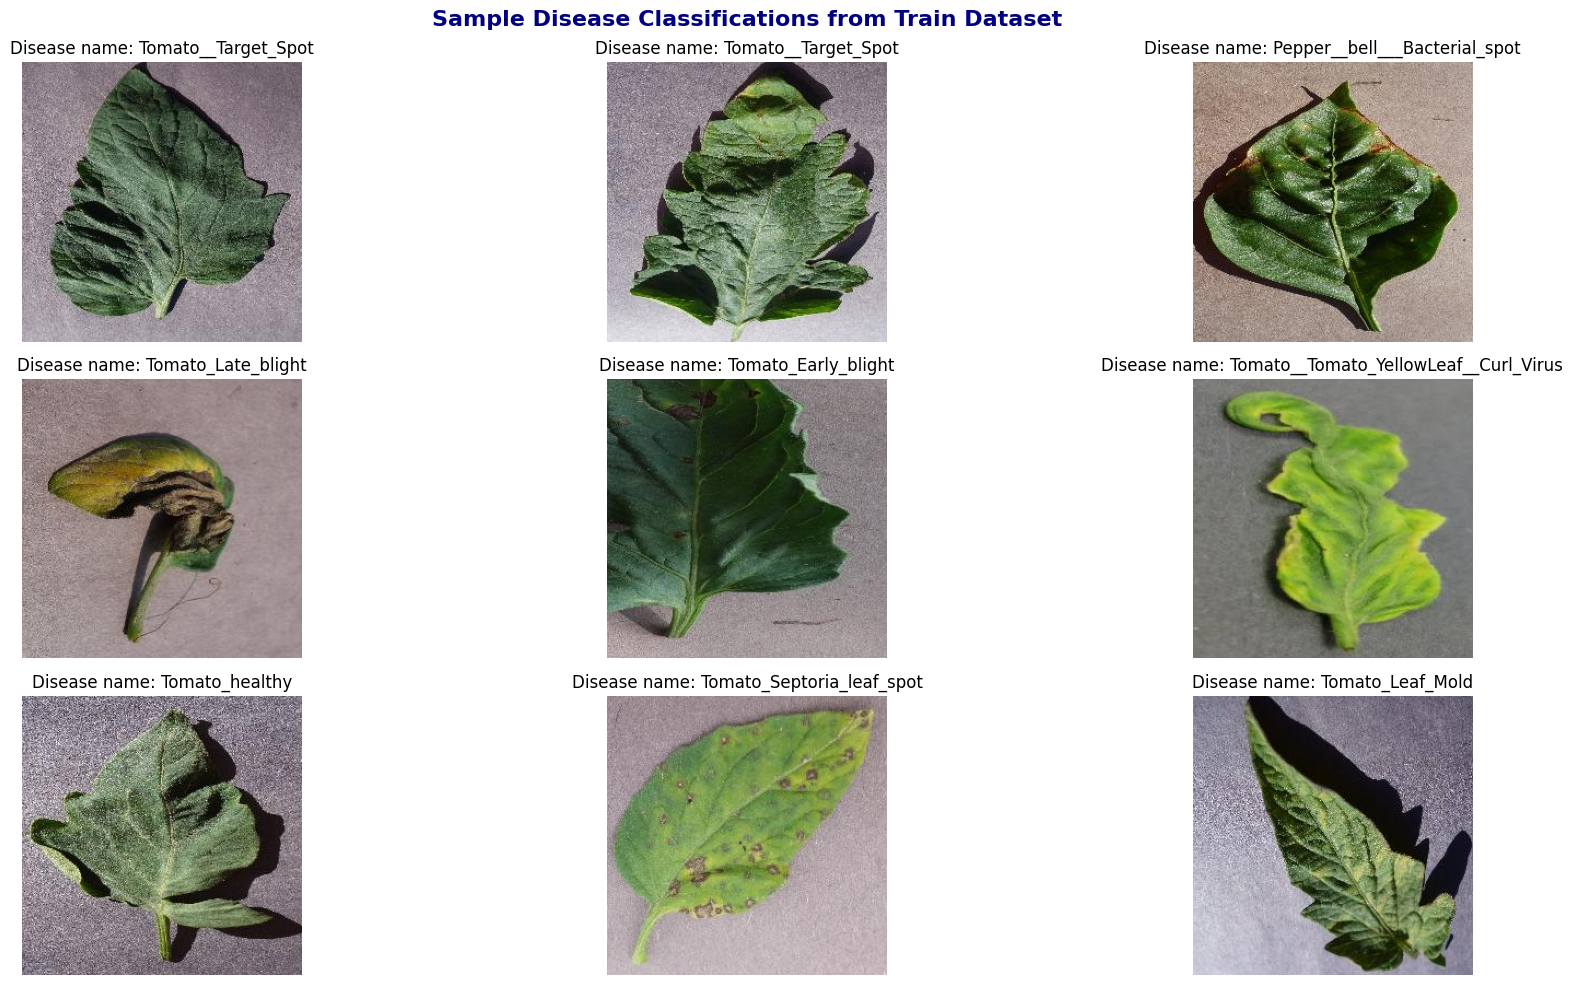

In [17]:
plotdata=datasets.ImageFolder(root=r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\PlantVillage")
classname=plotdata.classes
plt.style.use("seaborn-v0_8-muted")
plt.figure(figsize=(20,10))
rows,cols=3,3
for i in range(1,rows*cols+1):
    plt.subplot(rows,cols,i)
    randomid=torch.randint(0,len(plotdata),size=[1]).item()
    img,label=plotdata[randomid]
    plt.imshow(img)
    plt.title(f"Disease name: {classname[label]}")
    plt.axis(False)
plt.suptitle("Sample Disease Classifications from Train Dataset", fontsize=16, fontweight='bold', color='navy')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


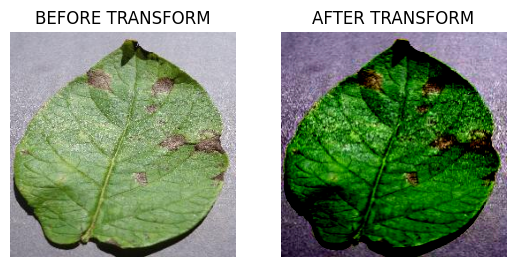

In [6]:
from pathlib import Path
from PIL import Image
import random
imagepath=Path(r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\PlantVillage")
data_transform = v2.Compose([
    v2.Resize((227, 227)),                            # Resize to AlexNet input size
    v2.ToImage(),                                     # Needed before color transforms
    v2.RandomHorizontalFlip(p=0.3),                   # Flip
    v2.ColorJitter(                                   # Randomly adjust brightness, contrast, etc.
        brightness=0.2,                               # ±20%
        contrast=0.2,
        saturation=0.2,
        hue=0.1                                       # hue ∈ [-0.1, 0.1]
    ),
    v2.RandomAutocontrast(p=0.2),                     # Random autocontrast
    v2.RandomAdjustSharpness(sharpness_factor=2, p=0.2),  # Sharpness boost
    v2.ToDtype(torch.float32, scale=True),            # Scale to [0, 1]
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])
def plot_original_transform(imagpath,transform):
    randomimglist=random.choice(list(imagepath.rglob('*.jpg')))
    image=Image.open(randomimglist).convert("RGB")
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("BEFORE TRANSFORM")
    plt.axis(False)
    transform_img=transform(image)
    plt.subplot(1,2,2)
    plt.imshow(transform_img.permute(1,2,0))
    plt.title("AFTER TRANSFORM")
    plt.axis(False)
plot_original_transform(imagepath,data_transform)

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
def check_imbalance_class(data):
    labels=[sample[1] for sample in data]
    class_count=Counter(labels)
    
    class_names = data.classes

    for i, counts in class_count.items():
     print(f"{class_names[i]}: {counts}")
     
    counts=np.array(list(class_count.values()))
    imbalance_ratio=counts.max()/counts.min()
    print(f"CLASS IMBALANCE RATION : {imbalance_ratio:.2f}")


     
    plt.figure(figsize=(20, 5))
    plt.bar([class_names[i] for i in class_count.keys()], class_count.values())
    plt.xticks(rotation=60, ha='right', fontsize=6)  # rotated + smaller font
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

Pepper__bell___Bacterial_spot: 997
Pepper__bell___healthy: 1478
Potato___Early_blight: 1000
Potato___Late_blight: 1000
Potato___healthy: 152
Tomato_Bacterial_spot: 2127
Tomato_Early_blight: 1000
Tomato_Late_blight: 1909
Tomato_Leaf_Mold: 952
Tomato_Septoria_leaf_spot: 1771
Tomato_Spider_mites_Two_spotted_spider_mite: 1676
Tomato__Target_Spot: 1404
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208
Tomato__Tomato_mosaic_virus: 373
Tomato_healthy: 1591
CLASS IMBALANCE RATION : 21.11


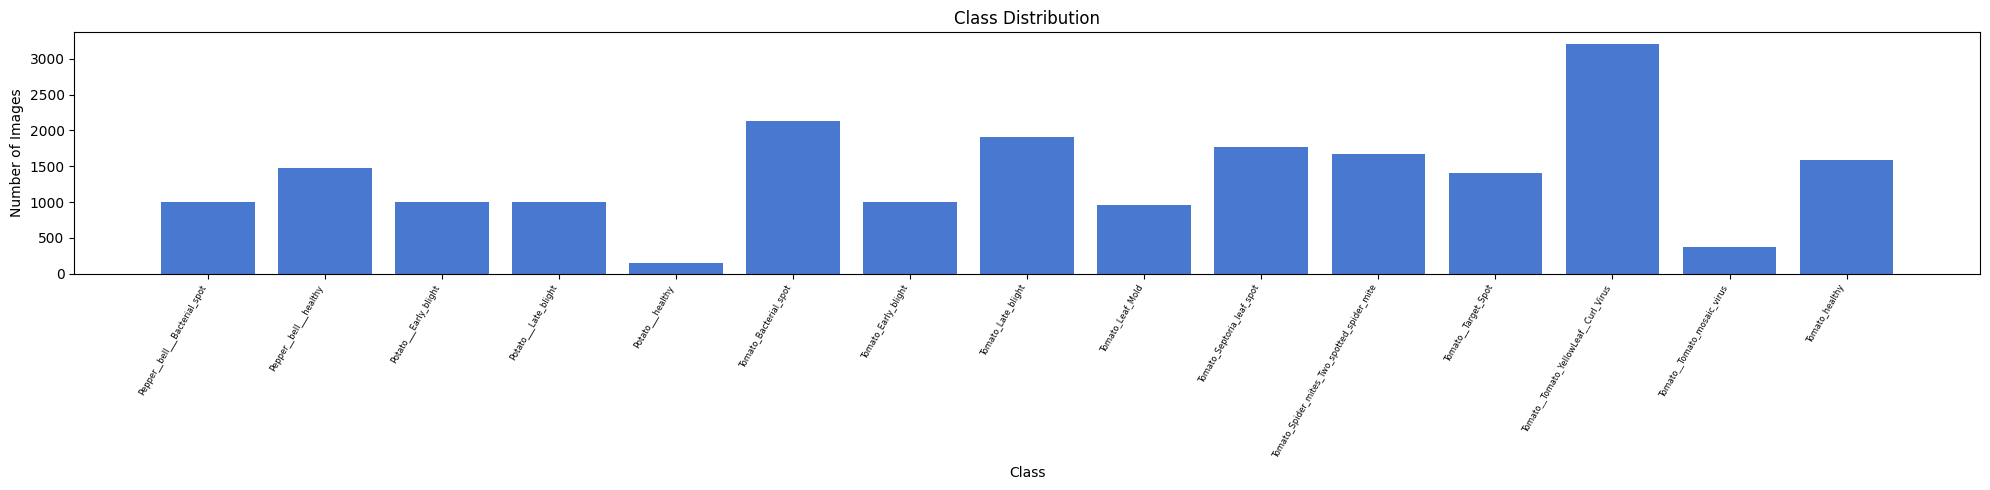

In [5]:
plantdata=plotdata
check_imbalance_class(plantdata)

In [2]:
def getloader(root_directory, batch_size, train_ratio, image_size):
    # Transform (ImageNet normalization for pretrained models like EfficientNet)
    data_transform = v2.Compose([
        v2.Resize((image_size, image_size)),
        v2.ToImage(),
        v2.RandomHorizontalFlip(p=0.3),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load dataset
    full_dataset = datasets.ImageFolder(root=root_directory, transform=data_transform)

    # Train-test split
    train_size = int(train_ratio * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # Calculate class weights for sampler (to handle class imbalance)
    train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
    class_counts = Counter(train_labels)
    class_weights = {label: 1.0 / count for label, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [3]:
root=r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\PlantVillage"
trainloader,testloader=getloader(root,32,0.8,227)

In [18]:
from collections import Counter
import torch

def count_class_distribution(dataloader):
    class_counts = Counter()
    for _, labels in dataloader:
        if isinstance(labels, torch.Tensor):
            labels = labels.tolist()
        class_counts.update(labels)
    return class_counts
train_class_counts = count_class_distribution(trainloader)
test_class_counts = count_class_distribution(testloader)

print("Train Class Distribution:", dict(train_class_counts))
print("Test Class Distribution:", dict(test_class_counts))


Train Class Distribution: {9: 1146, 3: 1117, 2: 1073, 8: 1132, 1: 1112, 5: 1108, 7: 1124, 14: 1072, 11: 1129, 12: 1091, 0: 1067, 6: 1130, 13: 1042, 4: 1104, 10: 1063}
Test Class Distribution: {7: 369, 12: 646, 11: 310, 5: 421, 3: 196, 14: 327, 6: 185, 2: 216, 13: 82, 0: 198, 8: 188, 10: 344, 9: 336, 4: 30, 1: 280}


In [4]:
len(trainloader)*32+len(testloader)*32,

(20640,)

In [5]:
train_feature_batch,train_label=next(iter(trainloader))
test_feature_batch,test_label=next(iter(testloader))

In [6]:
train_feature_batch.shape

torch.Size([32, 3, 227, 227])

In [ ]:
class CNN1(nn.Module):
    def __init__(self, input, hidden_units, output):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(hidden_units*2, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        with torch.inference_mode():
            dummy = torch.randn(1, input, 64, 64)
            x = self.conv_block1(dummy)
            x = self.conv_block2(x)
            x= self.conv_block3(x)
            x = nn.Flatten()(x)
            num_features = x.shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, output)  # No ReLU here
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x= self.conv_block3(x)
        return self.classifier(x)


In [81]:
from torchvision import models

# Load pre-trained AlexNet
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

In [82]:
import torch.nn as nn
from torchvision import models

def get_alexnet_model(num_class, mode='no_tune'):
    """
    Load AlexNet with specified fine-tuning mode.

    Args:
        num_class (int): Number of output classes
        mode (str): 'no_tune', 'partial', or 'full'

    Returns:
        model (nn.Module): AlexNet model ready to train
    """
    assert mode in ['no_tune', 'partial', 'full'], "Mode must be 'no_tune', 'partial', or 'full'"

    # Load pretrained AlexNet
    model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

    # Replace final FC layer FIRST (always do this before freezing/unfreezing)
    model.classifier[6] = nn.Linear(4096, num_class)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Apply fine-tuning mode
    if mode == 'partial':
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif mode == 'full':
        for param in model.parameters():
            param.requires_grad = True

    return model


In [83]:
def show_trainable_layers(model):
    print("🔍 Trainable layers in the model:\n")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"✅ {name}")
        else:
            print(f"❌ {name}")


In [40]:
classname=plotdata.classes

In [84]:
from torchinfo import summary
device='cuda' if torch.cuda.is_available() else 'cpu'
# model=CNN1(input=3,hidden_units=128,output=len(data.classes)).to(device)
model=get_alexnet_model(num_class=len(classname),mode='partial')

In [85]:
show_trainable_layers(model)

🔍 Trainable layers in the model:

❌ features.0.weight
❌ features.0.bias
❌ features.3.weight
❌ features.3.bias
❌ features.6.weight
❌ features.6.bias
❌ features.8.weight
❌ features.8.bias
❌ features.10.weight
❌ features.10.bias
✅ classifier.1.weight
✅ classifier.1.bias
✅ classifier.4.weight
✅ classifier.4.bias
✅ classifier.6.weight
✅ classifier.6.bias


In [86]:
summary(model,input_size=(32,3,227,227))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [32, 15]                  --
├─Sequential: 1-1                        [32, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 64, 56, 56]          (23,296)
│    └─ReLU: 2-2                         [32, 64, 56, 56]          --
│    └─MaxPool2d: 2-3                    [32, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [32, 192, 27, 27]         (307,392)
│    └─ReLU: 2-5                         [32, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [32, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [32, 384, 13, 13]         (663,936)
│    └─ReLU: 2-8                         [32, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [32, 256, 13, 13]         (884,992)
│    └─ReLU: 2-10                        [32, 256, 13, 13]         --
│    └─Conv2d: 2-11                      [32, 256, 13, 13]

In [87]:
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

In [88]:
from tqdm.auto import tqdm

In [91]:
def train(model, dataloader, lossfn, optimizer, device):
    model.train()
    trainloss, trainacc = 0, 0

    for batch, (x, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc='Training', leave=False):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = lossfn(pred, y)
        trainloss += loss.item()

        prob = torch.argmax(pred, dim=1)
        trainacc += accuracy_score(y.detach().cpu().numpy(), prob.detach().cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 200 == 0:
            tqdm.write(f"🟩 Looked at {batch * len(x)}/{len(dataloader.dataset)} | Loss: {loss.item():.4f}")

    trainloss /= len(dataloader)
    trainacc /= len(dataloader)
    print(f"\n✅ TRAINING COMPLETE — Loss: {trainloss:.4f} | Accuracy: {trainacc:.4f}")
    return trainloss, trainacc

def test(model, dataloader, lossfn, device):
    model.eval()
    testloss, testacc = 0, 0

    with torch.inference_mode():
        for batch, (x, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc='Testing', leave=False):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = lossfn(pred, y)
            testloss += loss.item()

            prob = torch.argmax(pred, dim=1)
            testacc += accuracy_score(y.detach().cpu().numpy(), prob.detach().cpu().numpy())

            if batch % 400 == 0:
                tqdm.write(f"🟦 Looked at {batch * len(x)}/{len(dataloader.dataset)} | Loss: {loss.item():.4f}")

    testloss /= len(dataloader)
    testacc /= len(dataloader)
    print(f"\n🔎 TESTING COMPLETE — Loss: {testloss:.4f} | Accuracy: {testacc:.4f}")
    return testloss, testacc

In [92]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter(log_dir='runs/experiment1')

In [93]:

best_acc = 0.0             
best_model_state = None    
patience = 2
counter = 0
min_delta = 0.001         

train_loss, train_acc, test_loss, test_acc = [], [], [], []

epochs=15
for epoch in tqdm(range(epochs), desc='Training', ncols=150):
    print(f"\nEpoch --> [{epoch+1}]")
    
    trainloss, trainacc = train(model, trainloader, loss, optimizer, device)
    testloss, testacc = test(model, testloader, loss, device)
    writer.add_scalar("Loss/Train", trainloss, epoch)
    writer.add_scalar("Loss/Test", testloss, epoch)
    writer.add_scalar("Accuracy/Train", trainacc, epoch)
    writer.add_scalar("Accuracy/Test", testacc, epoch)

    train_loss.append(trainloss)
    train_acc.append(trainacc)
    test_loss.append(testloss)
    test_acc.append(testacc)

    # 🔍 Check for improvement in test accuracy
    if testacc > best_acc + min_delta:
        best_acc = testacc
        counter = 0
        best_model_state = model.state_dict()  # Save best model in memory
        print(f"✅ Best model updated at epoch {epoch+1} with test accuracy: {testacc:.4f}")
    else:
        counter += 1
        print(f"🛑 No improvement. Patience: {counter}/{patience}")

    if counter >= patience:
        print(f"\n⛔ Early stopping triggered at epoch {epoch+1}. Best accuracy: {best_acc:.4f}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n🎯 Best model loaded with test accuracy: {best_acc:.4f}")
writer.close()



Training:   0%|                                                                                               …


Epoch --> [1]


Training:   0%|          | 0/516 [00:00<?, ?it/s]

🟩 Looked at 0/16510 | Loss: 2.9952
🟩 Looked at 6400/16510 | Loss: 0.8535
🟩 Looked at 12800/16510 | Loss: 0.3138

✅ TRAINING COMPLETE — Loss: 0.7448 | Accuracy: 0.7666


Testing:   0%|          | 0/129 [00:00<?, ?it/s]

🟦 Looked at 0/4128 | Loss: 0.1896

🔎 TESTING COMPLETE — Loss: 0.4371 | Accuracy: 0.8634
✅ Best model updated at epoch 1 with test accuracy: 0.8634

Epoch --> [2]


Training:   0%|          | 0/516 [00:00<?, ?it/s]

🟩 Looked at 0/16510 | Loss: 1.0452
🟩 Looked at 6400/16510 | Loss: 0.2535
🟩 Looked at 12800/16510 | Loss: 0.5139

✅ TRAINING COMPLETE — Loss: 0.5237 | Accuracy: 0.8455


Testing:   0%|          | 0/129 [00:00<?, ?it/s]

🟦 Looked at 0/4128 | Loss: 0.9120

🔎 TESTING COMPLETE — Loss: 0.4396 | Accuracy: 0.8786
✅ Best model updated at epoch 2 with test accuracy: 0.8786

Epoch --> [3]


Training:   0%|          | 0/516 [00:00<?, ?it/s]

🟩 Looked at 0/16510 | Loss: 0.3738
🟩 Looked at 6400/16510 | Loss: 0.4698
🟩 Looked at 12800/16510 | Loss: 0.5693

✅ TRAINING COMPLETE — Loss: 0.4770 | Accuracy: 0.8629


Testing:   0%|          | 0/129 [00:00<?, ?it/s]

🟦 Looked at 0/4128 | Loss: 0.1922

🔎 TESTING COMPLETE — Loss: 0.2934 | Accuracy: 0.9075
✅ Best model updated at epoch 3 with test accuracy: 0.9075

Epoch --> [4]


Training:   0%|          | 0/516 [00:00<?, ?it/s]

🟩 Looked at 0/16510 | Loss: 0.3615
🟩 Looked at 6400/16510 | Loss: 0.3029
🟩 Looked at 12800/16510 | Loss: 0.2127

✅ TRAINING COMPLETE — Loss: 0.4082 | Accuracy: 0.8786


Testing:   0%|          | 0/129 [00:00<?, ?it/s]

🟦 Looked at 0/4128 | Loss: 0.1904

🔎 TESTING COMPLETE — Loss: 0.2957 | Accuracy: 0.9213
✅ Best model updated at epoch 4 with test accuracy: 0.9213

Epoch --> [5]


Training:   0%|          | 0/516 [00:00<?, ?it/s]

🟩 Looked at 0/16510 | Loss: 0.2931
🟩 Looked at 6400/16510 | Loss: 0.4665
🟩 Looked at 12800/16510 | Loss: 0.4824

✅ TRAINING COMPLETE — Loss: 0.3951 | Accuracy: 0.8884


Testing:   0%|          | 0/129 [00:00<?, ?it/s]

🟦 Looked at 0/4128 | Loss: 0.2378

🔎 TESTING COMPLETE — Loss: 0.2443 | Accuracy: 0.9334
✅ Best model updated at epoch 5 with test accuracy: 0.9334

Epoch --> [6]


Training:   0%|          | 0/516 [00:00<?, ?it/s]

🟩 Looked at 0/16510 | Loss: 0.2591
🟩 Looked at 6400/16510 | Loss: 1.1137
🟩 Looked at 12800/16510 | Loss: 0.2285

✅ TRAINING COMPLETE — Loss: 0.3747 | Accuracy: 0.8970


Testing:   0%|          | 0/129 [00:00<?, ?it/s]

🟦 Looked at 0/4128 | Loss: 0.0997

🔎 TESTING COMPLETE — Loss: 0.2338 | Accuracy: 0.9329
🛑 No improvement. Patience: 1/2

Epoch --> [7]


Training:   0%|          | 0/516 [00:00<?, ?it/s]

🟩 Looked at 0/16510 | Loss: 0.4903
🟩 Looked at 6400/16510 | Loss: 0.0804
🟩 Looked at 12800/16510 | Loss: 0.2573

✅ TRAINING COMPLETE — Loss: 0.3363 | Accuracy: 0.9073


Testing:   0%|          | 0/129 [00:00<?, ?it/s]

🟦 Looked at 0/4128 | Loss: 0.3448

🔎 TESTING COMPLETE — Loss: 0.2545 | Accuracy: 0.9288
🛑 No improvement. Patience: 2/2

⛔ Early stopping triggered at epoch 7. Best accuracy: 0.9334

🎯 Best model loaded with test accuracy: 0.9334


In [94]:
dummy_input = torch.randn(1, 3, 227, 227).to(device)  
writer.add_graph(model, dummy_input)


In [95]:
images, labels = next(iter(trainloader))

# Log input images
img_grid = torchvision.utils.make_grid(images[:16])  # First 16 images
writer.add_image('Sample Inputs', img_grid)


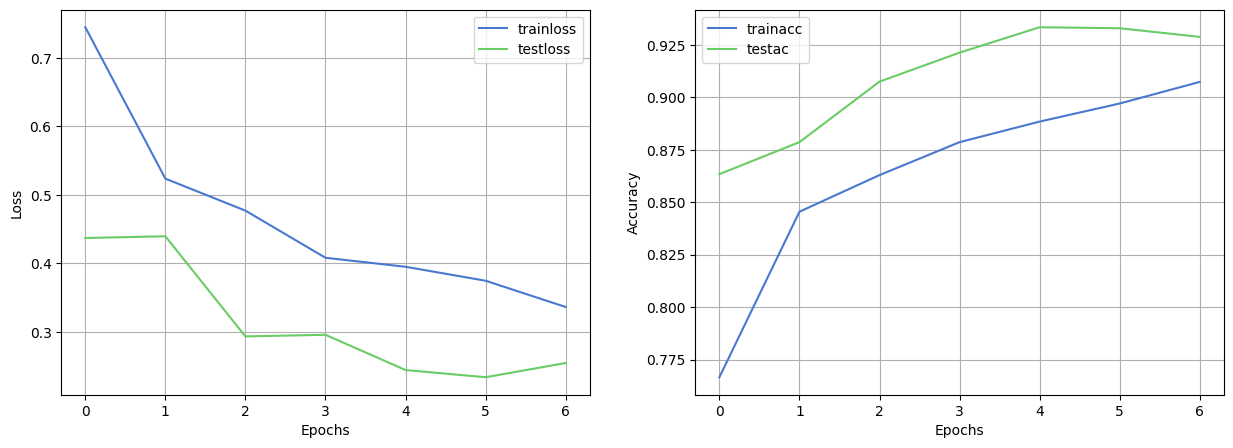

In [96]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss,)
plt.plot(test_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['trainloss','testloss'])
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(train_acc,)
plt.plot(test_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['trainacc','testac'])
plt.grid(True)
plt.show()

In [97]:
y_pred,y_true=[],[]
model.eval()
with torch.inference_mode():
    for (xsam,ysam) in (testloader):
        xsam,ysam=xsam.to(device),ysam.to(device)
        testpred=model(xsam)
        testpred=torch.softmax(testpred,dim=1)
        testprob=torch.argmax(testpred,dim=1)
        y_pred.extend(testprob.detach().cpu().numpy())
        y_true.extend(ysam.detach().cpu().numpy())

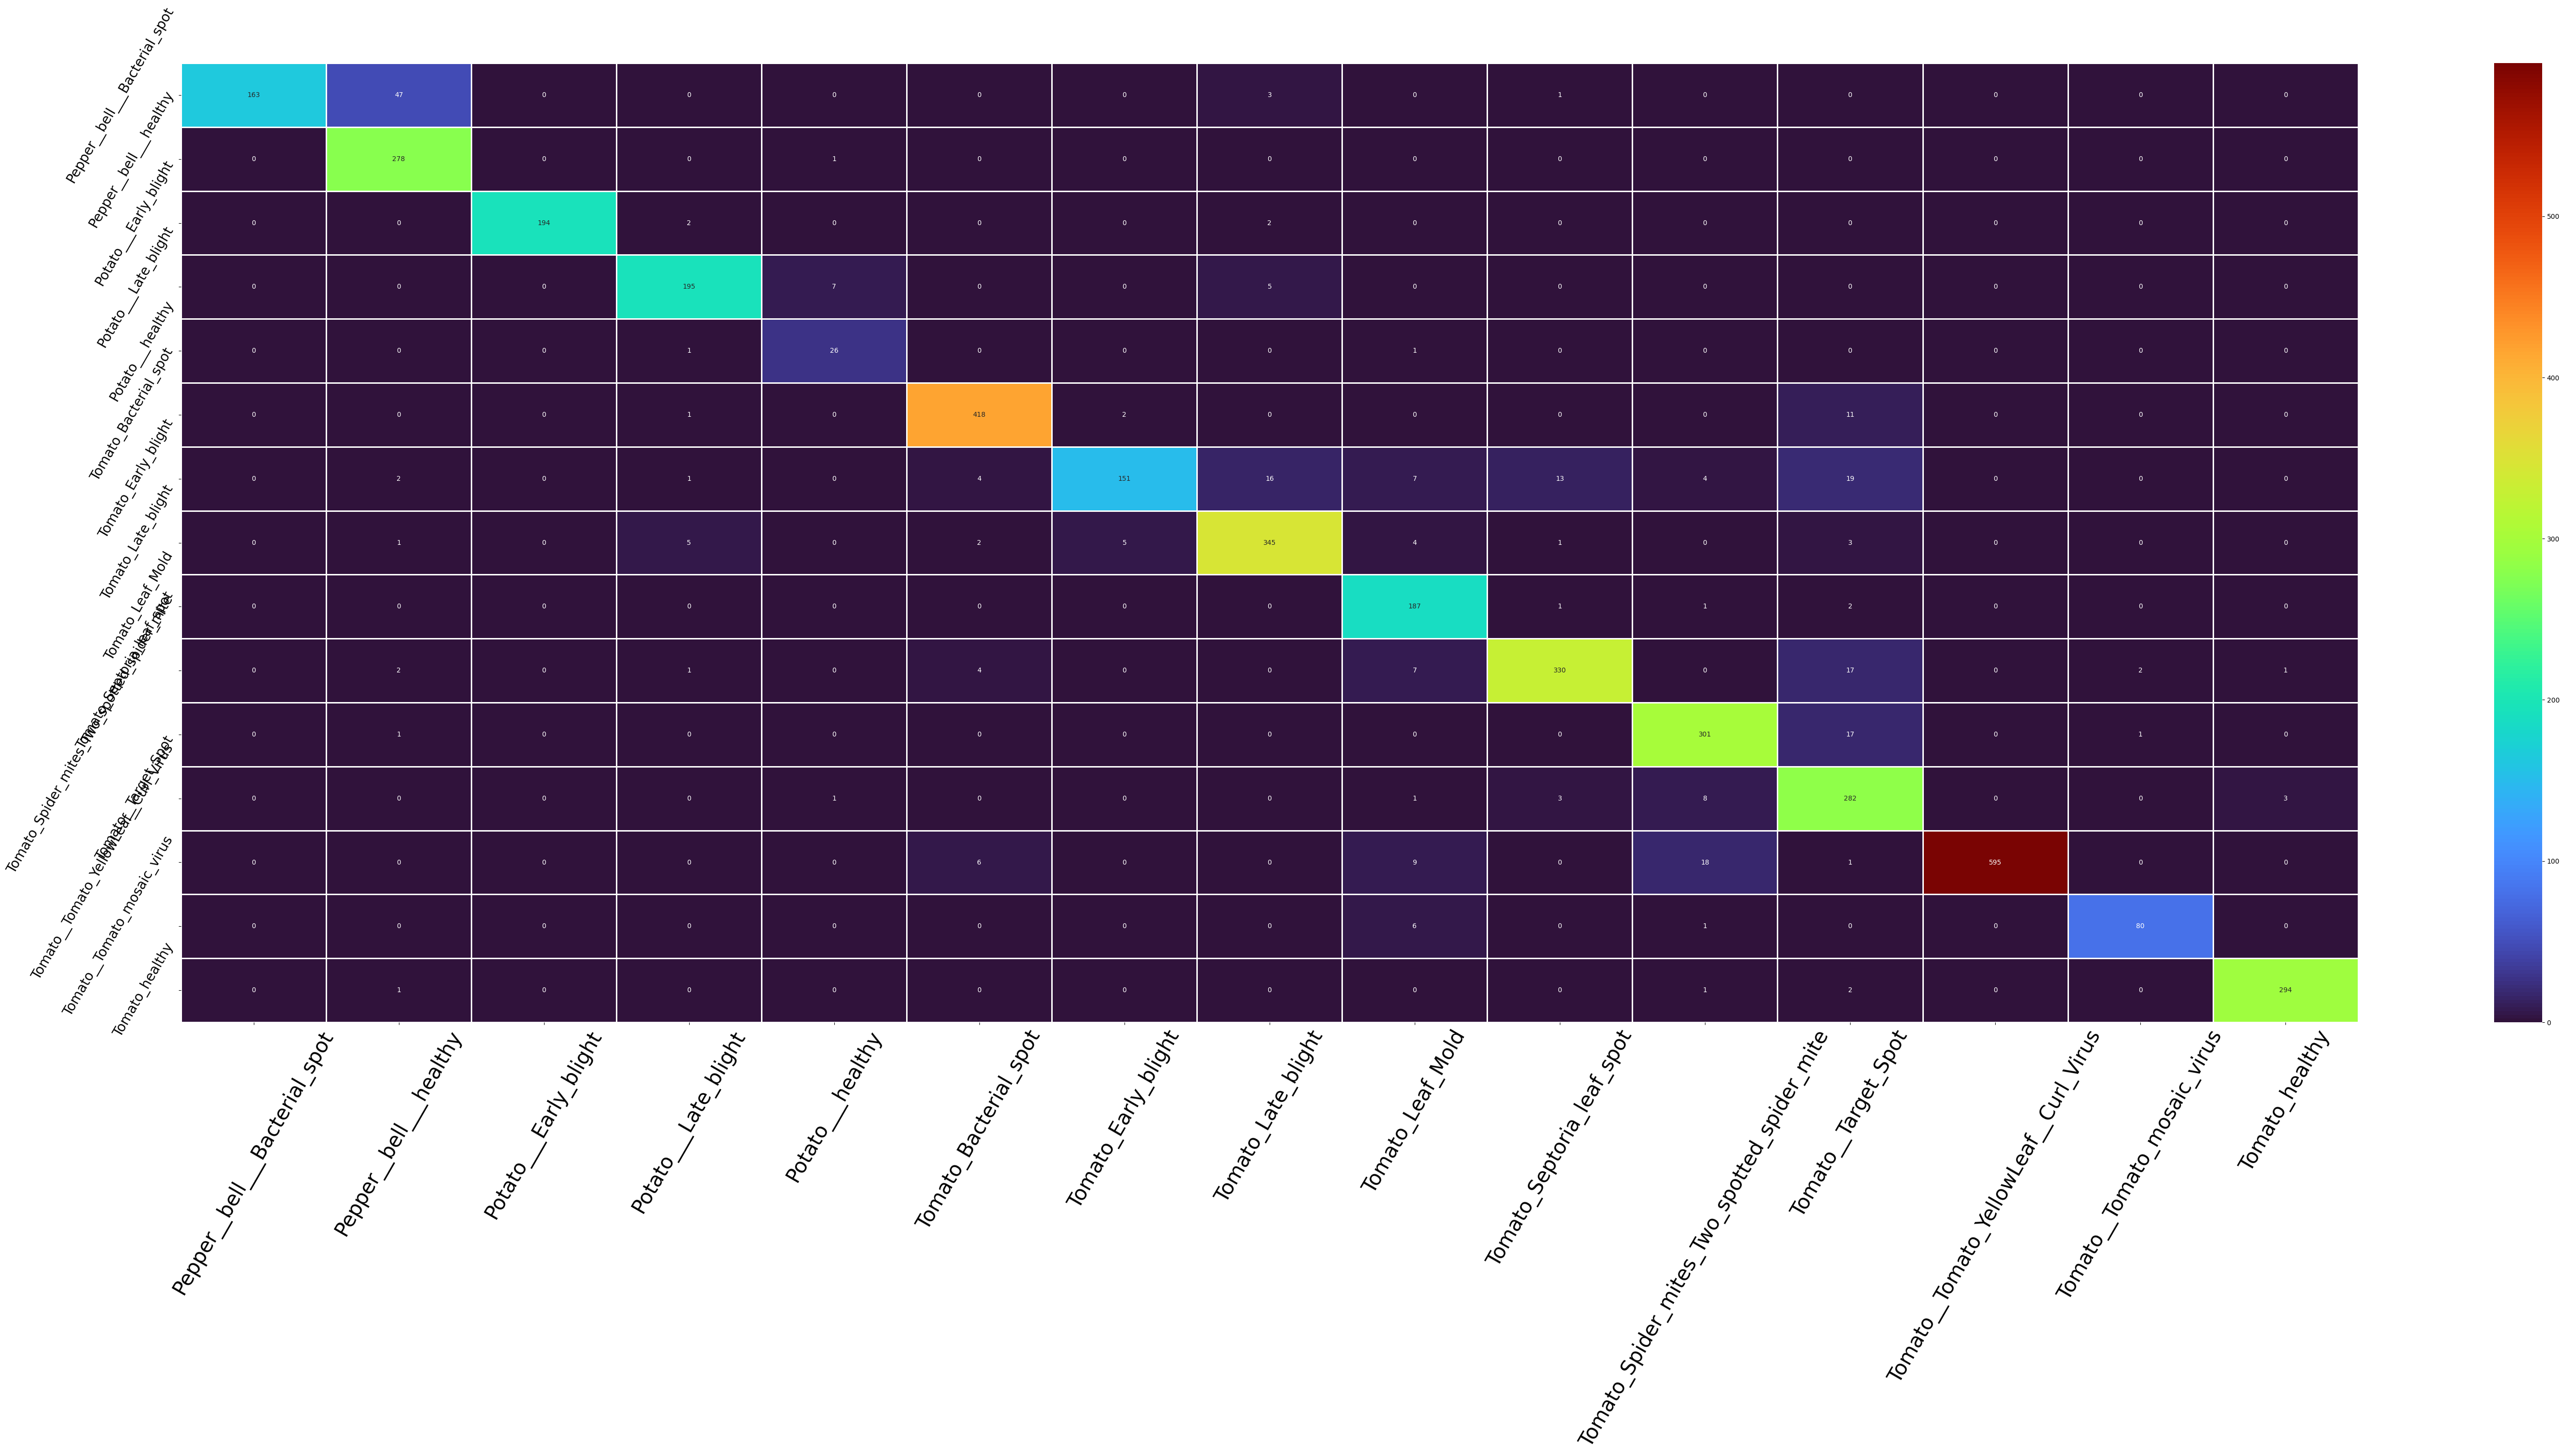

In [98]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(60,30))
sns.heatmap(cm,fmt='d',annot=True,cmap=plt.cm.turbo,xticklabels=plotdata.classes,yticklabels=plotdata.classes,linecolor='white',linewidths=1.0)
plt.xticks(fontsize=30,rotation=60)
plt.yticks(fontsize=20,rotation=60)
plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(258.5), np.float64(193.5), np.float64(-0.5))

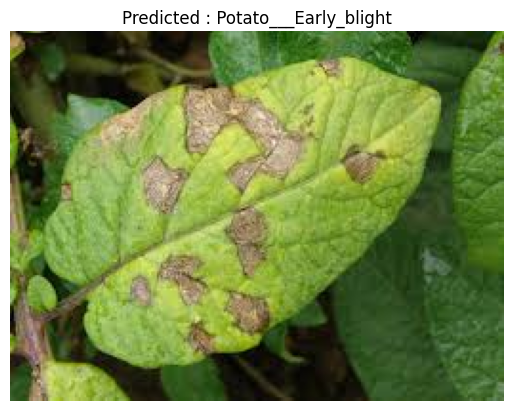

In [58]:
from PIL import Image

img=Image.open(r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\TESTIMAGE\potato_early_blight.jpg").convert("RGB")
transform=transform=v2.Compose([
    v2.Resize((64,64)),
    v2.ToImage(),
    v2.RandomHorizontalFlip(p=0.3),
    v2.ToDtype(torch.float32,scale=True),
    v2.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
    ])
transform_img=transform(img).unsqueeze(0).to(device)
with torch.inference_mode():
    logit=model(transform_img)
    pred=torch.softmax(logit,dim=1)
    prob=torch.argmax(pred,dim=1)
class_name=plotdata.classes
plt.imshow(img)
plt.title(f"Predicted : {class_name[prob]}")
plt.axis(False)

In [100]:
torch.save(model, r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\MODELS\alexnet_full_model.pth")